In [2]:
import numpy as np
import torch as pt
from matplotlib import pyplot as plt
import sys
from pathlib import Path
import src.constants as constants
import sys
from display_data.data_acquisition_shadow import derandomized_classical_shadow, randomized_classical_shadow
from display_data.prediction_shadow import estimate_exp
sys.path.append(Path('../src'))
from src.mps import MPS
from src.tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from src.mps_quantum_state import MPSQuantumState

In [2]:
#generate a random tensor list
qubit_num = 10
bond_dim = 50
tensor_liste = [pt.randn([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))

In [3]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [4]:
ratio_h_j = 0.1
qubit_num = 6
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)

In [5]:
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
energy_dict = np.load(save_direc_eigs, allow_pickle=True)
energy_dict = energy_dict.item()
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

-5.020016662087988


In [8]:
# now we have a method to keep only the unique indices, now we convert the measurements to the necessary shape for shadow prediction
batches = 10
num_of_measurements = np.array([10, 20, 50, 100, 200, 500])
num_of_measurements_per_rot = 10
energies_different_meas_num = np.zeros((np.size(num_of_measurements), batches))
for b in range(batches):
    for i in range(np.size(num_of_measurements)):
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements[i], num_of_measurements_per_rot)
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            # first get the unique elements of this torch tensor
            unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
            #probs_sorted = probs[n][index_perm] # if we just want to compute the energy we can easily use these probabilities we get for free when sampling
            # when we want to determine the gradient via autodiff though, the connection to the underlying tensors has to be more direct
            # thus we compute the probabilities again, from the tensors directly
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(unique_meas_outcomes))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
        energy = pt.mean(energies)
        energies_different_meas_num[i,b] = energy

tensor([0.0134, 0.0134, 0.0162, 0.0179])
tensor([0.0134, 0.0134, 0.0162, 0.0179], dtype=torch.float64)
tensor([0.0651, 0.0588, 0.0719, 0.0588, 0.0719])
tensor([0.0651, 0.0588, 0.0719, 0.0588, 0.0719], dtype=torch.float64)
tensor(-8.9386)


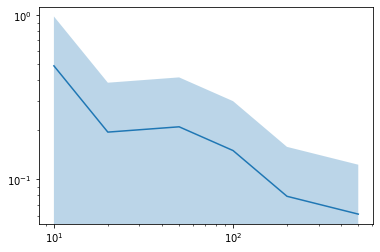

In [6]:
rel_error = np.abs((energies_different_meas_num - energy_brute) / energy_brute)
rel_error_mean = np.mean(rel_error, axis=1)
rel_error_std = np.mean(rel_error, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std, alpha=0.3)
plt.yscale('log')
plt.xscale('log')

In [6]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
qubit_num = 6
ratio_h_j = 0.1
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [7]:
# we estimate the energy exactly by contraction with the hamiltonian
random_param_vec_brute = random_param_vec.detach()
random_param_vec_brute.requires_grad_(True)
mps.from_param_vec(param_vec=random_param_vec_brute)
psi = mps.to_state_vector()
hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
energy_bf = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
print(f'BF E = {energy_bf}')
energy_bf.backward()

BF E = (0.6086901323107693+6.205934920115456e-18j)


In [8]:
bf_grad = np.copy(random_param_vec_brute.grad.numpy())
print(bf_grad)

[ 1.04154690e-03-0.00073557j -1.63590417e-03-0.00053835j
  1.52810756e-03-0.00126977j ... -1.50590689e-03-0.00064837j
  4.46126769e-05+0.00053518j -1.70894880e-04-0.00086003j]


In [9]:
random_param_vec_shadow = random_param_vec.detach()
random_param_vec_shadow.requires_grad_(True)

tensor([0.3061+0.1573j, 0.4927+0.9303j, 0.1393+0.7299j,  ...,
        0.1754+0.8582j, 0.6062+0.1045j, 0.5575+0.7099j],
       dtype=torch.complex128, requires_grad=True)

In [10]:
random_param_vec_shadow.grad

In [18]:
# now we estimate the gradient by using the classical shadows
random_param_vec_shadow = random_param_vec.detach()
random_param_vec_shadow.requires_grad_(True)
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.from_param_vec(param_vec=random_param_vec_shadow)
#mps.normalise()
mps.tensors[0] = mps.tensors[0] / mps.norm()
num_of_measurements = 100
num_of_measurements_per_rot = 100
meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot)
energies = pt.zeros(len(meas_outcomes))
for n in range(len(meas_outcomes)):
    # first get the unique elements of this torch tensor
    unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
    # probs_sorted = probs[n][index_perm] # if we just want to compute the energy we can easily use these probabilities we get for free when sampling
    # when we want to determine the gradient via autodiff though, the connection to the underlying tensors has to be more direct
    # thus we compute the probabilities again, from the tensors directly
    probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(unique_meas_outcomes))
    measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
    energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
energy_shadow = pt.mean(energies)
print(f'SH E = {energy_shadow}')

energy_shadow.backward()

SH E = 0.6225056648254395


In [19]:
random_param_vec_shadow.grad

tensor([ 0.0008-0.0009j, -0.0009-0.0007j,  0.0009-0.0013j,  ...,
        -0.0017-0.0006j,  0.0008+0.0007j, -0.0009-0.0008j],
       dtype=torch.complex128)

In [20]:
random_param_vec_brute.grad

tensor([ 1.0415e-03-0.0007j, -1.6359e-03-0.0005j,  1.5281e-03-0.0013j,
         ..., -1.5059e-03-0.0006j,  4.4613e-05+0.0005j,
        -1.7089e-04-0.0009j], dtype=torch.complex128)

In [ ]:
print(energy_shadow)
print(energy)
print(random_param_vec_brute.grad)
print(random_param_vec_shadow.grad)
print(pt.linalg.norm((random_param_vec_brute.grad - random_param_vec_shadow.grad)/pt.linalg.norm(random_param_vec_brute.grad)))
print(pt.linalg.norm(random_param_vec_brute.grad))

In [ ]:
# we do gradient descent with the exact hamiltonian contraction method and see whether we converge to the ground state

In [9]:
# doing gradient descent using pytorch optimizer
step_num = 500
lr = 0.01
random_param_vec_brute = random_param_vec.detach()
random_param_vec_brute.requires_grad_(True)
opt = pt.optim.Adam([random_param_vec_brute], lr=lr)

accuracy = np.zeros(step_num)
for i in range(0, step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec = random_param_vec_brute)
    psi = mps.to_state_vector()
    hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
    energy = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
    energy.backward()
    accuracy[i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()

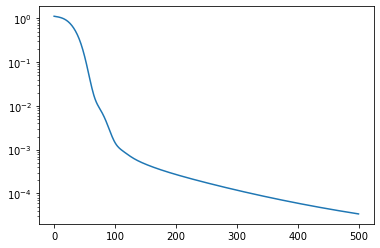

In [10]:
plt.plot(np.arange(0, step_num), accuracy)
plt.yscale('log')

In [13]:
# doing gradient descent using pytorch optimizer
step_num = 20
lr = 0.01
random_param_vec_shadow = random_param_vec.detach()
random_param_vec_shadow.requires_grad_(True)
opt = pt.optim.Adam([random_param_vec_shadow], lr=lr)
num_of_measurements = 100
num_of_measurements_per_rot = 20 #this has to be high enough, if there is only one unique measurement outcome aleksei's amplitude method fails

accuracy = np.zeros(step_num)
for i in range(step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec=random_param_vec_shadow)
    mps.normalise()
    with pt.no_grad():
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot)
    energies = pt.zeros(len(meas_outcomes))
    for n in range(len(meas_outcomes)):
        # first get the unique elements of this torch tensor
        unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
        # probs_sorted = probs[n][index_perm] # if we just want to compute the energy we can easily use these probabilities we get for free when sampling
        # when we want to determine the gradient via autodiff though, the connection to the underlying tensors has to be more direct
        # thus we compute the probabilities again, from the tensors directly
        probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(unique_meas_outcomes))
        measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
        energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
    energy_shadow = pt.mean(energies)
    energy_shadow.backward()
    accuracy[i] = np.abs(energy_shadow.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()
    print('progress: ' + str(i) + ' / ' + str(step_num))

progress: 0 / 20
progress: 1 / 20
progress: 2 / 20
progress: 3 / 20
progress: 4 / 20
progress: 5 / 20
progress: 6 / 20
progress: 7 / 20
progress: 8 / 20
progress: 9 / 20
progress: 10 / 20
progress: 11 / 20
progress: 12 / 20
progress: 13 / 20
progress: 14 / 20
progress: 15 / 20
progress: 16 / 20
progress: 17 / 20
progress: 18 / 20
progress: 19 / 20


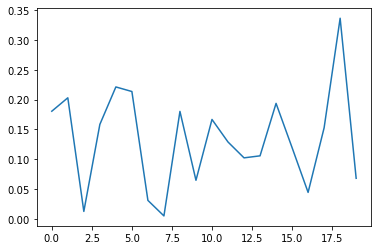

In [14]:
plt.plot(np.arange(0, step_num), accuracy)